In [102]:
'''
File name: preprocessing.ipynb
Authors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt
Date created: 04/11/2022
Date last modified: 15/11/2022
Python version: 3.8.8
'''

'\nFile name: preprocessing.ipynb\nAuthors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt\nDate created: 04/11/2022\nDate last modified: 15/11/2022\nPython version: 3.8.8\n'

# MeToo
Analyze the evolution of sexism and women discrimination in the film industry through the roles/job they are given. Did the MeToo movement change things?

## Table of contents

0. [General Information](#GI)\
        A. [Folder structure](#Folder)\
        B. [Imports](#Imports)\
        C. [Paths](#Paths)
</br> 
1. [Step 1: Data scraping, pre-processing and dataset construction](#Step-1)\
        A. [Box Office](#Box Office)\
        B. [detecting main characters] (#Main Characters)\
</br> 


---
## General Information <a id="GI"> </a> 

### Folder structure <a id="Folder"> </a>

***Files and directories to make this notebook run successfully:***

- **data/**
    - *character.metadata.tsv*
    - *movie.metadata.tsv*
    - *name.clusters.txt*
    - *plot_summaries.txt*
    - *tvtropes.clusters.txt*
    - *oscar_winners.csv*
    - *movie_appreciation_metadata.csv*


- *preprocessing.ipynb*

Directories are in **bold** and files are in *italic*.


### Imports <a id="Imports"> </a>

***Libraries used for milestone 2:***
- python=3.8.12
- pandas
- datetime
- numpy
- matplotlib

In [4]:
#Imports used in this notebook
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json as js 
import ast
import datetime as dt


### Paths <a id="Paths"> </a>

Required to adapt those path to local file organization

In [6]:
### PATHs for dataset:
PATH_DATA = 'data/'
PATH_MOVIE_METADATA = PATH_DATA+'movie.metadata.tsv'
PATH_PLOT_SUMMARY = PATH_DATA+'plot_summaries.txt'
PATH_CHARACTER_METADATA = PATH_DATA+'character.metadata.tsv'
PATH_NAME_CLUSTERS=PATH_DATA+'name.clusters.txt'
PATH_TV_TROPES_CLUSTERS=PATH_DATA+'tvtropes.clusters.txt'

---
## **Step 1: Data scraping, pre-processing and dataset construction** <a id="Step-1"> </a>

In [7]:
def dict_to_cols(row): 
    '''
    allows to transform the dictionnary into  a dataframe with multiple columns 
    '''
    d = js.loads(row[1])
    return row[0], *list(d.values())

def dict_to_lst(str):
    '''
    allows to transform a dictionnary into a list of features
    '''
    
    dict = ast.literal_eval(str)
    lst  = list(dict.values())
    return lst

First we will properly name ecach column of  in order to manipulate in an easier way

In [11]:
print("Reading in movie data")


movie_headers = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name','Movie_release_date','Movie_box_office_revenue',
                 'Movie_runtime','Movie_languages','Movie_countries','Movie_genres']
plot_headers = ['Wikipedia_movie_ID','Plot_Summary']
character_headers = ['Wikipedia_movie_ID', 'Freebase_movie_ID','Movie_release_date','Character_name','Actor_date_of_birth',
                     'Actor_gender','Actor_height','Actor_ethnicity','Actor_name','Actor_age_at_movie_release',
                     'Freebase_character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID']
name_clusters_headers=['Character_name', 'id']
name_clusters_headers=['Character_name', 'id']
tv_tropes_cluster_headers=['Trope','Character_name','movie','id','actor']

#Read in movie metadata, plot summaries, and character metadata.
movie_metadata = pd.read_csv(PATH_MOVIE_METADATA,sep='\t',header=None,names=movie_headers,index_col=0)
plot_summaries = pd.read_csv(PATH_PLOT_SUMMARY,sep='\t',index_col=0,names=plot_headers)
character_metadata = pd.read_csv(PATH_CHARACTER_METADATA,sep='\t',header=None,names=character_headers,index_col='Wikipedia_movie_ID')
name_clusters=pd.read_csv(PATH_NAME_CLUSTERS,sep='\t',header=None,names=name_clusters_headers,index_col='id')
tv_tropes_clusters = pd.read_csv(PATH_TV_TROPES_CLUSTERS,sep='\t',header=None).apply(dict_to_cols, axis=1, result_type='expand')
tv_tropes_clusters.columns = tv_tropes_cluster_headers
tv_tropes_clusters.set_index('id')
movie_metadata['Movie_languages']=movie_metadata['Movie_languages'].apply(lambda x: dict_to_lst(x))
movie_metadata['Movie_countries']=movie_metadata['Movie_countries'].apply(lambda x: dict_to_lst(x))
movie_metadata['Movie_genres']=movie_metadata['Movie_genres'].apply(lambda x: dict_to_lst(x))
movie_metadata


Reading in movie data


,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama]
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]"


We can see that some values are missing, movie languages, movie countries and movie genres are lists. Also the dates don't all have the same format, in fact, some are missing the month and day. 

In [13]:
name_clusters.head()

,Character_name
id,
/m/0k3w9c,Stuart Little
/m/0k3wcx,Stuart Little
/m/0k3wbn,Stuart Little
/m/0jyg35,John Doe
/m/0k2_zn,John Doe


This data set shows the characters appearing in different movies. This might be unuselful for our analysis since we analyse movies one by one

First of all, we make an inspection of the dataframes, to see wether there exist some duplicates, NaN values etc... 

In [14]:
movie_metadata.index.is_unique

True

In [15]:
movie_metadata.isna().any()

Freebase_movie_ID           False
Movie_name                  False
Movie_release_date           True
Movie_box_office_revenue     True
Movie_runtime                True
Movie_languages             False
Movie_countries             False
Movie_genres                False
dtype: bool

here is a more visual way to see which columns of the dataset contain missing entries

Sum of NaN in each feature : 


Freebase_movie_ID               0
Movie_name                      0
Movie_release_date           6902
Movie_box_office_revenue    73340
Movie_runtime               20450
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
dtype: int64

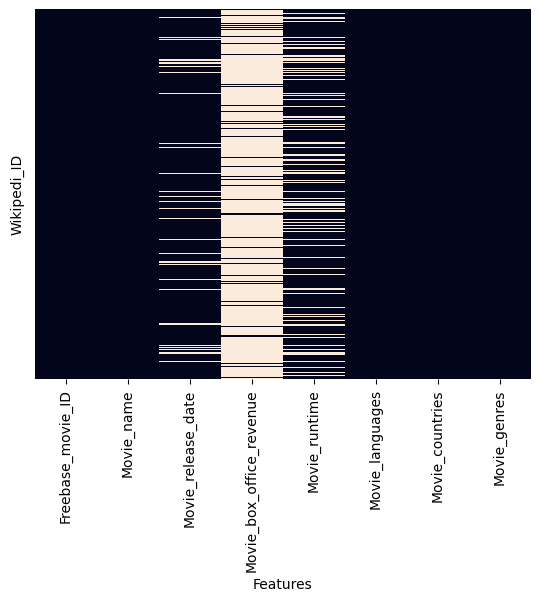

In [21]:
ax=sns.heatmap(movie_metadata.isna(), yticklabels=False,cbar=False)
ax.set(xlabel="Features", ylabel="Wikipedi_ID")
print('Sum of NaN in each feature : ')
movie_metadata.isna().sum(axis = 0)

In [22]:
n_movie=len(movie_metadata)
print('Percentage of missing entries in the movie.metadata dataset:\n', 100*movie_metadata[['Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime']].isna().sum() / n_movie)

Percentage of missing entries in the movie.metadata dataset:
 Movie_release_date           8.443743
Movie_box_office_revenue    89.722416
Movie_runtime               25.018045
dtype: float64


We are missing a lot of the data on the movie box office revenue. Maybe we should try and find those missing informations in another dataset as this could be helpful in our analysis.

In [23]:
plot_summaries.head()

,Plot_Summary
Wikipedia_movie_ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


In [24]:
plot_summaries.index.is_unique

True

In [25]:
print('Sum of NaN in each feature : ')
plot_summaries.isna().sum(axis = 0)

Sum of NaN in each feature : 


Plot_Summary    0
dtype: int64

The summary dataset seems to be relatively clean 

In [26]:
character_metadata.head()

,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [27]:
character_metadata.isna().any()

Freebase_movie_ID                  False
Movie_release_date                  True
Character_name                      True
Actor_date_of_birth                 True
Actor_gender                        True
Actor_height                        True
Actor_ethnicity                     True
Actor_name                          True
Actor_age_at_movie_release          True
Freebase_character_actor_map_ID    False
Freebase_character_ID               True
Freebase_actor_ID                   True
dtype: bool

Sum of NaN in each feature : 


Freebase_movie_ID                       0
Movie_release_date                   9995
Character_name                     257875
Actor_date_of_birth                106145
Actor_gender                        45609
Actor_height                       295845
Actor_ethnicity                    344611
Actor_name                           1228
Actor_age_at_movie_release         158113
Freebase_character_actor_map_ID         0
Freebase_character_ID              257865
Freebase_actor_ID                     815
dtype: int64

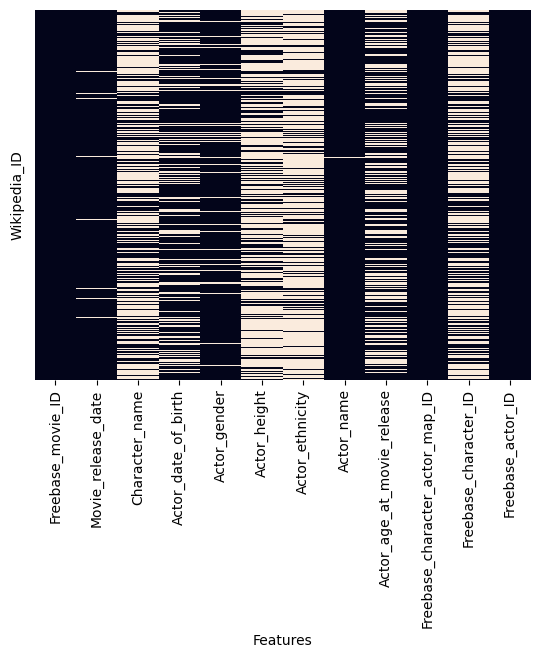

In [29]:
ax=sns.heatmap(character_metadata.isna(), yticklabels=False,cbar=False)
ax.set(xlabel="Features", ylabel="Wikipedia_ID")
print('Sum of NaN in each feature : ')
character_metadata.isna().sum(axis = 0)

In [30]:
n_char=len(character_metadata)
print('Percentage of missing entries in the character.metadata dataset:\n', 100*character_metadata[['Freebase_movie_ID', 'Movie_release_date', 'Character_name',
                                                                                   'Actor_date_of_birth', 'Actor_gender', 'Actor_height', 'Actor_ethnicity',
                                                                                   'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_ID',
                                                                                   'Freebase_actor_ID']].isna().sum() / n_char)

Percentage of missing entries in the character.metadata dataset:
 Freebase_movie_ID              0.000000
Movie_release_date             2.217814
Character_name                57.220488
Actor_date_of_birth           23.552763
Actor_gender                  10.120288
Actor_height                  65.645740
Actor_ethnicity               76.466542
Actor_name                     0.272484
Actor_age_at_movie_release    35.084064
Freebase_character_ID         57.218269
Freebase_actor_ID              0.180842
dtype: float64


We are missing a lot of data on actor's and actresses' ethnicities and their heights. This should not affect our analysis a we did not plan on using these features initially.

In [31]:
print('Number of rows in the movie.metadata dataset : %d' %n_movie)
print('Number of rows in the character.metadata dataset : %d' %n_char)

Number of rows in the movie.metadata dataset : 81741
Number of rows in the character.metadata dataset : 450669


In [32]:
print("What is needed to be processed:")
print("Rows with actor age at movie release under or equal to 0: %d" %len(character_metadata[character_metadata['Actor_age_at_movie_release']<=0]))
print("Rows with actor height under or equal to 0: %d" %len(character_metadata[character_metadata['Actor_height']<=0]))
print("Rows with movie runtime under or equal to 0: %d" %len(movie_metadata[movie_metadata['Movie_runtime']<=0]))

What is needed to be processed:
Rows with actor age at movie release under or equal to 0: 433
Rows with actor height under or equal to 0: 0
Rows with movie runtime under or equal to 0: 1


In [33]:
#Looking for duplicates in our datasets
for f in movie_metadata.columns:
    dupl = movie_metadata[f].duplicated().sum()
    print("{} has {} duplicated rows".format(f, dupl))

Freebase_movie_ID has 0 duplicated rows
Movie_name has 6263 duplicated rows
Movie_release_date has 61351 duplicated rows
Movie_box_office_revenue has 74378 duplicated rows
Movie_runtime has 81143 duplicated rows
Movie_languages has 79924 duplicated rows
Movie_countries has 79617 duplicated rows
Movie_genres has 57924 duplicated rows


In [ ]:
movie_metadata[movie_metadata["Movie_name"]=="Hunting Season"]

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]"


In [ ]:
movie_metadata.dtypes

Freebase_movie_ID            object
Movie_name                   object
Movie_release_date           object
Movie_box_office_revenue    float64
Movie_runtime               float64
Movie_languages              object
Movie_countries              object
Movie_genres                 object
dtype: object

Some dates only include de the year

In [ ]:
#01-01-Year for movies only including a year for the dates
movie_metadata["Movie_release_date"] = pd.to_datetime(movie_metadata["Movie_release_date"],errors='coerce') 
movie_metadata

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama]
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]"


We can see that the release date of this movie is wrong. 1010-12-02 should be 2010-12-03.

In [ ]:
movie_metadata.loc[movie_metadata['Movie_release_date'] == '1010-12-02','Movie_release_date'] = '2010-12-02'

In [ ]:
movie_metadata[movie_metadata["Movie_name"]=="Hunting Season"]

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
29666067,/m/0fphzrf,Hunting Season,NaT,12160978.0,140.0,"[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]"


the last film in our dataframe was released in 2016 and the first one in 1888


/var/folders/4n/zzxjf3fs0fqbmxgbcht_g0cw0000gn/T/ipykernel_2624/1069636430.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


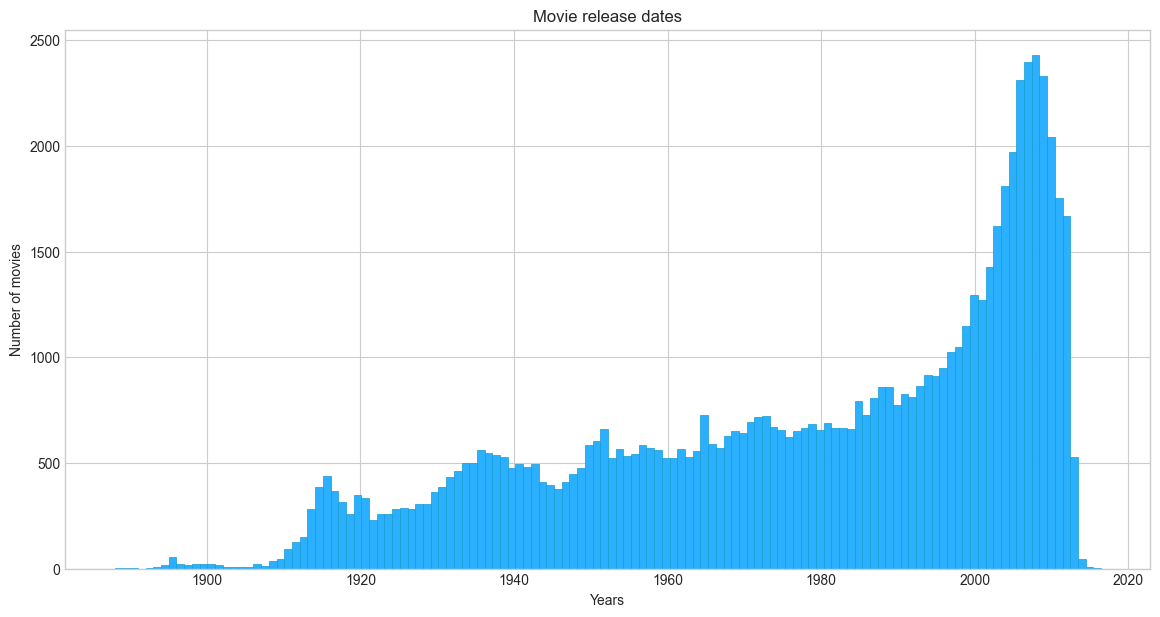

In [ ]:
'''
sns.histplot(data=movie_metadata, x='Movie_runtime')
plt.title('Movie_release_year') je ne suis pas arrivé à mettre le histplot 
'''
print('the last film in our dataframe was released in', movie_metadata.Movie_release_date.max().year,'and the first one in',movie_metadata.Movie_release_date.min().year)
num_years=(movie_metadata.Movie_release_date.max().year-movie_metadata.Movie_release_date.min().year)

plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')
plt.hist(movie_metadata['Movie_release_date'],bins=num_years, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Movie release dates') 
plt.xlabel('Years') 
plt.ylabel('Number of movies') 
plt.show()

As we can see the first film seems to have been released in 1888, it is in fact a short sequence of less than 3 seconds. But for our analysis it isn't releavant. Even if there is a debate on which is the fisrt "real movie" we will consider that it is "A trip to the Moon", which is often taught at school. So we will consider movies starting from 1902, and this seems relevant in view of the plot above! 
Source: https://www.studiobinder.com/blog/what-was-the-first-movie-ever-made/

In [ ]:
movie_metadata=movie_metadata[~(movie_metadata['Movie_release_date'] <= '1902-01-01')]

In [ ]:
'''
movie_metadata['Movie release date'] = pd.to_datetime(movie_metadata['Movie release date'],format='%Y-%m-%d').dt.year
character_metadata['Movie release date'] = pd.to_datetime(character_metadata['Movie release date'],format='%Y-%m-%d').dt.year
character_metadata['Actor date of birth'] = pd.to_datetime(character_metadata['Actor date of birth'],format='%Y-%m-%d').dt.year
'''

"\nmovie_metadata['Movie release date'] = pd.to_datetime(movie_metadata['Movie release date'],format='%Y-%m-%d').dt.year\ncharacter_metadata['Movie release date'] = pd.to_datetime(character_metadata['Movie release date'],format='%Y-%m-%d').dt.year\ncharacter_metadata['Actor date of birth'] = pd.to_datetime(character_metadata['Actor date of birth'],format='%Y-%m-%d').dt.year\n"

## additional datasets preprocess 

In [ ]:
### PATHs for dataset:
PATH_DATA = 'data/'
PATH_MOVIE_OSCAR_WINNERS = PATH_DATA+'oscar_winners.csv'
PATH_MOVIE_APPRECIATION = PATH_DATA+'movie_appreciation_metadata.csv'

In [ ]:
'''movie_headers = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name','Movie_release_date','Movie_box_office_revenue',
                 'Movie_runtime','Movie_languages','Movie_countries','Movie_genres']
plot_headers = ['Wikipedia_movie_ID','Plot_Summary']
character_headers = ['Wikipedia_movie_ID', 'Freebase_movie_ID','Movie_release_date','Character_name','Actor_date_of_birth',
                     'Actor_gender','Actor_height','Actor_ethnicity','Actor_name','Actor_age_at_movie_release',
                     'Freebase_character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID']
name_clusters_headers=['Character_name', 'id']
name_clusters_headers=['Character_name', 'id']
tv_tropes_cluster_headers=['Trope','Character_name','movie','id','actor']'''

movie_appreciation_metadata = pd.read_csv(PATH_MOVIE_APPRECIATION,header=0)
movie_appreciation_metadata.drop(['color','movie_imdb_link'], axis=1)
new_cols_apprec=['movie_title','director name','duration','country','actor_1_name','actor_2_name','actor_3_name',
                    'movie_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
                    'director_facebook_likes','gross','genres','num_voted_users','cast_total_facebook_likes',
                    'facenumber_in_poster','num_user_for_reviews','content_rating','budget',
                    'title_year','imdb_score','aspect_ratio'
                    ]
movie_apprciation_metadata=movie_appreciation_metadata.reindex(columns=new_cols_apprec)
movie_apprciation_metadata

,movie_title,director name,duration,country,actor_1_name,actor_2_name,actor_3_name,movie_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,...,genres,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,content_rating,budget,title_year,imdb_score,aspect_ratio
0,Avatar,NaN,178.0,USA,CCH Pounder,Joel David Moore,Wes Studi,33000,1000.0,936.0,...,Action|Adventure|Fantasy|Sci-Fi,886204,4834,0.0,3054.0,PG-13,237000000.0,2009.0,7.9,1.78
1,Pirates of the Caribbean: At World's End,NaN,169.0,USA,Johnny Depp,Orlando Bloom,Jack Davenport,0,40000.0,5000.0,...,Action|Adventure|Fantasy,471220,48350,0.0,1238.0,PG-13,300000000.0,2007.0,7.1,2.35
2,Spectre,NaN,148.0,UK,Christoph Waltz,Rory Kinnear,Stephanie Sigman,85000,11000.0,393.0,...,Action|Adventure|Thriller,275868,11700,1.0,994.0,PG-13,245000000.0,2015.0,6.8,2.35
3,The Dark Knight Rises,NaN,164.0,USA,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,164000,27000.0,23000.0,...,Action|Thriller,1144337,106759,0.0,2701.0,PG-13,250000000.0,2012.0,8.5,2.35
4,Star Wars: Episode VII - The Force Awakens ...,NaN,NaN,NaN,Doug Walker,Rob Walker,NaN,0,131.0,12.0,...,Documentary,8,143,0.0,NaN,NaN,NaN,NaN,7.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Signed Sealed Delivered,NaN,87.0,Canada,Eric Mabius,Daphne Zuniga,Crystal Lowe,84,637.0,470.0,...,Comedy|Drama,629,2283,2.0,6.0,NaN,NaN,2013.0,7.7,NaN
5039,The Following,NaN,43.0,USA,Natalie Zea,Valorie Curry,Sam Underwood,32000,841.0,593.0,...,Crime|Drama|Mystery|Thriller,73839,1753,1.0,359.0,TV-14,NaN,NaN,7.5,16.00
5040,A Plague So Pleasant,NaN,76.0,USA,Eva Boehnke,Maxwell Moody,David Chandler,16,0.0,0.0,...,Drama|Horror|Thriller,38,0,0.0,3.0,NaN,1400.0,2013.0,6.3,NaN
5041,Shanghai Calling,NaN,100.0,USA,Alan Ruck,Daniel Henney,Eliza Coupe,660,946.0,719.0,...,Comedy|Drama|Romance,1255,2386,5.0,9.0,PG-13,NaN,2012.0,6.3,2.35


In [ ]:
movie_oscar_winners=pd.read_csv(PATH_MOVIE_OSCAR_WINNERS,header=0)
movie_oscar_winners=movie_oscar_winners.replace('1927/1928','1928').replace('1928/1929','1929').replace(
    '1929/1930','1930').replace('1930/1931','1931').replace('1931/1932','1932').replace('1932/1933','1933')
#c'est vraiment dégeulasse comme manière de faire 
movie_oscar_winners

,Year,Ceremony,Award,Winner,Name,Film
0,1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson
...,...,...,...,...,...,...
9959,2015,88,Writing (Original Screenplay),1.0,Spotlight,Written by Josh Singer & Tom McCarthy
9960,2015,88,Writing (Original Screenplay),NaN,Straight Outta Compton,Screenplay by Jonathan Herman and Andrea Berlo...
9961,2015,88,Jean Hersholt Humanitarian Award,1.0,Debbie Reynolds,NaN
9962,2015,88,Honorary Award,1.0,Spike Lee,NaN


In [ ]:
movie_appreciation_metadata.isna().any()

color                         True
director_name                 True
num_critic_for_reviews        True
duration                      True
director_facebook_likes       True
actor_3_facebook_likes        True
actor_2_name                  True
actor_1_facebook_likes        True
gross                         True
genres                       False
actor_1_name                  True
movie_title                  False
num_voted_users              False
cast_total_facebook_likes    False
actor_3_name                  True
facenumber_in_poster          True
plot_keywords                 True
movie_imdb_link              False
num_user_for_reviews          True
language                      True
country                       True
content_rating                True
budget                        True
title_year                    True
actor_2_facebook_likes        True
imdb_score                   False
aspect_ratio                  True
movie_facebook_likes         False
dtype: bool

Sum of NaN in each feature : 


color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

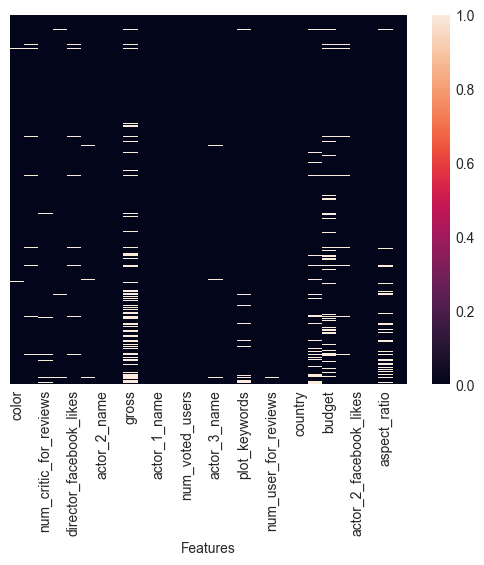

In [ ]:
ax=sns.heatmap(movie_appreciation_metadata.isna(), yticklabels=False)
ax.set(xlabel="Features", ylabel="")
print('Sum of NaN in each feature : ')
movie_appreciation_metadata.isna().sum(axis = 0)

In [ ]:
movie_oscar_winners.isna().any()

Year        False
Ceremony    False
Award       False
Winner       True
Name        False
Film         True
dtype: bool

We do not consider the column 'winner' as it contains indicators ( 1 and 0) to check wether a movie, an actor, a director has won the oscar. 

Sum of NaN in each feature : 


Year          0
Ceremony      0
Award         0
Name          0
Film        333
dtype: int64

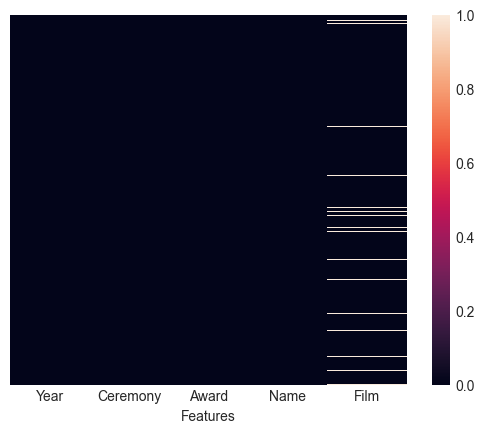

In [ ]:
ax=sns.heatmap(movie_oscar_winners[['Year','Ceremony','Award','Name','Film']].isna(), yticklabels=False)
ax.set(xlabel="Features", ylabel="")
print('Sum of NaN in each feature : ')
movie_oscar_winners[['Year','Ceremony','Award','Name','Film']].isna().sum(axis = 0)

## First analyses gender related 

In [ ]:
fem_act = character_metadata[character_metadata['Actor gender'] == 'F']
masc_act = character_metadata[character_metadata['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata')
plt.show()

KeyError: 'Actor gender'

In [ ]:
#replace NaN values with 0
character_metadata_clean = character_metadata.fillna(0)
movie_metadata_clean = movie_metadata.fillna(0)

In [ ]:

#new dataframe with movies after 2007 after converting the release date to datetime some dates are only year so we need to add the month and day

movie_metadata_clean['Movie release date'] = pd.to_datetime(movie_metadata_clean['Movie release date'],errors='coerce')
movie_metadata_clean = movie_metadata_clean[movie_metadata_clean['Movie release date'] > datetime(2007,1,1)]
movie_metadata_clean.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,0.0,0.0,{},{},{}
23124260,/m/064mmw7,Jeepers Creepers 4,2016-06-08,0.0,0.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}"


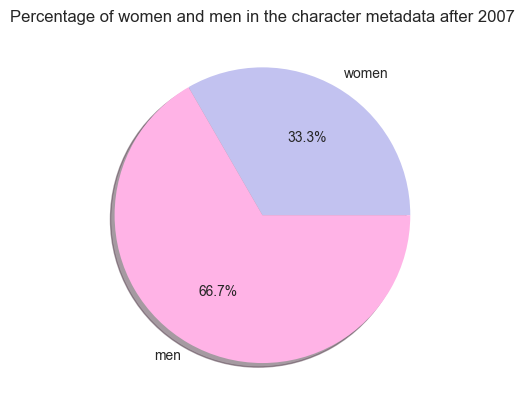

In [ ]:
#only keep characters with 'wikipedia movie ID' in movie_metadata_clean after 2007
character_metadata_clean = character_metadata_clean[character_metadata_clean.index.isin(movie_metadata_clean.index)]
#number of female actors compared to male actors for movies after 2007 plotted in a pie chart
fem_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'F']
masc_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata after 2007')
plt.show()

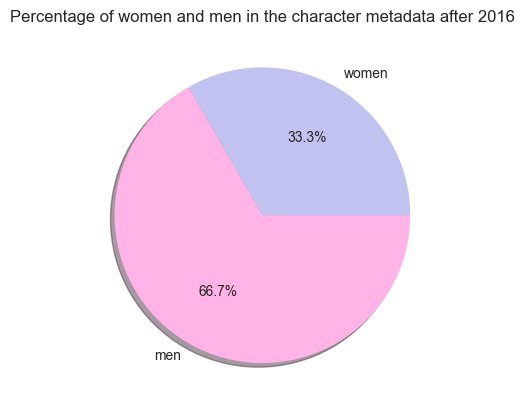

In [ ]:
#new dataframe with movies after 2016 
movie_metadata_clean = movie_metadata_clean[movie_metadata_clean['Movie release date'] > datetime(2016,1,1)]
#only keep characters with 'wikipedia movie ID' in movie_metadata_clean after 2016
character_metadata_clean = character_metadata_clean[character_metadata_clean.index.isin(movie_metadata_clean.index)]
#number of female actors compared to male actors for movies after 2016 plotted in a pie chart
fem_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'F']
masc_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata after 2016')
plt.show()

In [ ]:

plot_summaries
#merge character metadata with plot summaries

plot_summaries = plot_summaries.join(character_metadata, on='Wikipedia_movie_ID')
plot_summaries=plot_summaries.dropna()
plot_summaries

,Plot_Summary,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,,
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Gale Hawthorne,1990-01-13,M,1.910,/m/0bbz66j,Liam Hemsworth,22.0,/m/0gw7kv7,/m/0ds96_p,/m/04yd0fh
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Caesar Flickerman,1960-11-11,M,1.721,/m/0xnvg,Stanley Tucci,51.0,/m/0gw7kw1,/m/0gwc3bn,/m/02bj6k
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,President Snow,1935-07-17,M,1.930,/m/07bch9,Donald Sutherland,76.0,/m/0gwc391,/m/0dsbx11,/m/0ywqc
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Cinna,1964-05-26,M,1.740,/m/041rx,Lenny Kravitz,47.0,/m/0gw7kvx,/m/0gwc39n,/m/0161sp
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Claudius Templesmith,1966-09-07,M,1.650,/m/0d7wh,Toby Jones,45.0,/m/0j5lh7t,/m/0j5lh7x,/m/071ywj
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8605430,The story develops around the evolution of Tit...,/m/0279p_0,2002,Titli,1979-12-03,F,1.550,/m/0dryh9k,Konkona Sen Sharma,22.0,/m/02tb7xb,/m/04hqnqj,/m/09w3dt
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Leo Zhukovsky,1964-02-16,M,1.830,/m/02w7gg,Christopher Eccleston,38.0,/m/0jzpw0,/m/0h0v5q0,/m/02cbs0
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Niels,1965-11-22,M,1.830,/m/0268_k,Mads Mikkelsen,36.0,/m/04d89tq,/m/0h39rc3,/m/076svb


/var/folders/4n/zzxjf3fs0fqbmxgbcht_g0cw0000gn/T/ipykernel_2624/3673826918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_summaries_new['Movie_release_date'] = pd.to_datetime(plot_summaries_new['Movie_release_date'],errors='coerce')
/var/folders/4n/zzxjf3fs0fqbmxgbcht_g0cw0000gn/T/ipykernel_2624/3673826918.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_summaries_new['Movie_release_date'] = plot_summaries_new['Movie_release_date'].dt.year
/var/folders/4n/zzxjf3fs0fqbmxgbcht_g0cw0000gn/T/i

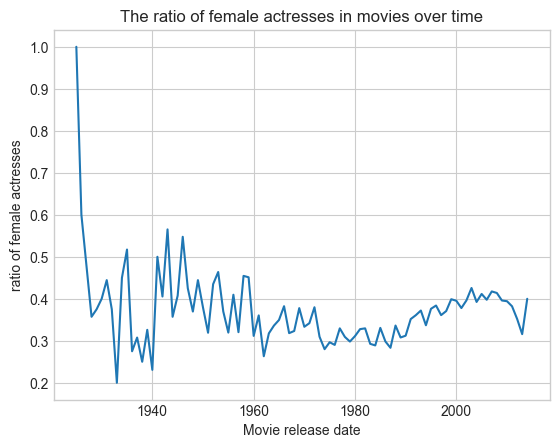

In [ ]:
#create new dataframe where we change movie release date to datetime in plot_summaries
plot_summaries_new = plot_summaries[['Freebase_movie_ID', 'Movie_release_date','Actor_gender']]
plot_summaries_new['Movie_release_date'] = pd.to_datetime(plot_summaries_new['Movie_release_date'],errors='coerce')
plot_summaries_new['Movie_release_date'] = plot_summaries_new['Movie_release_date'].dt.year
plot_summaries_new
#calculate the number of 'F' for every 'Movie release date'
plot_summaries_new = plot_summaries_new.groupby(['Movie_release_date','Actor_gender']).size().reset_index(name='counts')
plot_summaries_new[170:180]
#add the total counts for every 'Movie release date'
plot_summaries_new['total_counts'] = plot_summaries_new.groupby('Movie_release_date')['counts'].transform('sum')
plot_summaries_new
#find the ratio of 'F' counts to total counts for every 'Movie release date'
plot_summaries_new['ratio'] = plot_summaries_new.groupby('Movie_release_date')['counts'].apply(lambda x: x/x.sum())
plot_summaries_new
#only keep the 'F' rows
plot_summaries_new = plot_summaries_new[plot_summaries_new['Actor_gender'] == 'F']
plot_summaries_new
#plot the 'Movie release date' and 'ratio' in a line graph
plt.plot(plot_summaries_new['Movie_release_date'], plot_summaries_new['ratio'])
plt.xlabel('Movie release date')
plt.ylabel('ratio of female actresses')
plt.title('The ratio of female actresses in movies over time')
plt.show()



In [ ]:
#analysing plot summaries to find main character is the one whose name is mentioned the most
#we will use the first 1000 characters of the plot summary to find the main character

#function to find the main character in a plot summary
def find_main_character(plot_summary):
    #create a list of all the characters in the plot summary
    characters = character_metadata_clean[character_metadata_clean.index == plot_summary.name]['Character name'].to_list()
    #create a list of the number of times each character is mentioned in the plot summary
    character_count = [plot_summary['Plot Summary'][:2000].count(character) for character in characters]
    #return the character with the highest number of mentions
    return characters[np.argmax(character_count)]   

#apply the function to the plot summaries
#plot_summaries['Main character'] = plot_summaries.apply(find_main_character(plot_summaries),axis=1)
#plot_summaries.head()

## Salaries, box office revenues, etc.

In [ ]:
#Find movies without box office revenue and filter them out
no_rev = movie_metadata.loc[movie_metadata['Movie_box_office_revenue'].isnull()].index
movie_metadata_filt = movie_metadata.drop(no_rev)

In [ ]:
movie_metadata.shape[0]

81529

In [ ]:
movie_metadata_filt.shape[0]

8401

We only have 8401 movies where we have their box office revenue.

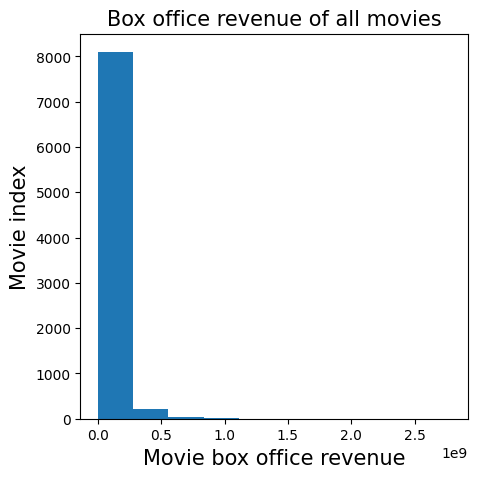

In [ ]:
#Histogram of box office revenue of movies

plt.figure(figsize=(5,5), dpi = 100)
plt.xlabel('Movie box office revenue', fontsize = 15)
plt.ylabel('Movie index', fontsize=15)
plt.title('Box office revenue of all movies', fontsize=15)

plt.hist(movie_metadata_filt['Movie box office revenue'])

plt.show()

In [ ]:
print("Movies with biggest box office revenues:")
movie_metadata.sort_values('Movie_box_office_revenue', ascending = False).head()

Movies with biggest box office revenues:


,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"[English Language, Spanish Language]","[United States of America, United Kingdom]","[Thriller, Science Fiction, Adventure, Compute..."
52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"[Italian Language, English Language, French La...",[United States of America],"[Tragedy, Costume drama, Historical fiction, A..."
22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"[Russian Language, English Language]",[United States of America],"[Science Fiction, Action]"
31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,[English Language],"[United States of America, United Kingdom]","[Drama, Mystery, Fantasy, Adventure]"
25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,[English Language],[United States of America],"[Alien Film, Science Fiction, Action, Adventure]"


In [ ]:
#No real use just to see
'''
plt.figure(figsize=(5,5), dpi = 100)
plt.xlabel('Movie release date', fontsize = 15)
plt.ylabel('Box office revenue', fontsize=15)
plt.title('Box office revenue of all movies', fontsize=15)

plt.plot(movie_metadata_filt["Movie release date"],movie_metadata_filt['Movie box office revenue'])

plt.show()
'''

'\nplt.figure(figsize=(5,5), dpi = 100)\nplt.xlabel(\'Movie release date\', fontsize = 15)\nplt.ylabel(\'Box office revenue\', fontsize=15)\nplt.title(\'Box office revenue of all movies\', fontsize=15)\n\nplt.plot(movie_metadata_filt["Movie release date"],movie_metadata_filt[\'Movie box office revenue\'])\n\nplt.show()\n'

In [ ]:
character_dropna = character_metadata.dropna()
character_dropna

,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
2314463,/m/0734w5,2006,Taper Guy,1971-05-26,M,1.870,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
612710,/m/02wjqm,1999-10-01,Sandii,1975-09-20,F,1.680,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq
...,...,...,...,...,...,...,...,...,...,...,...,...
22330502,/m/05sync6,1931-01-31,Yvonne Valbret,1905-09-18,F,1.702,/m/06mvq,Greta Garbo,25.0,/m/05tg4vb,/m/0h2ppfw,/m/0h14h
24997872,/m/09g6klx,2010-05-07,Raja,1951-09-07,M,1.780,/m/04mvp8,Mammootty,58.0,/m/0gvytkx,/m/0h27wx_,/m/02hkv5
24997872,/m/09g6klx,2010-05-07,Surya,1982-10-16,M,1.810,/m/0dryh9k,Prithviraj Sukumaran,27.0,/m/0gw0rm2,/m/0gz549m,/m/0cqcgj


In [ ]:
'''
character_dropna['Actor gender'] = pd.get_dummies(character_dropna['Actor gender'])
character_dropna.head()
'''

"\ncharacter_dropna['Actor gender'] = pd.get_dummies(character_dropna['Actor gender'])\ncharacter_dropna.head()\n"

## Detecting Main characters etc.

In [ ]:
plot_summaries.head()
character_metadata.head()
character_metadata=character_metadata.drop_duplicates()
print('there are normally', len(character_metadata),'characters')

there are normally 450669 characters


In [ ]:
character_dropna_name = character_metadata.dropna(subset=['Character_name'])
print('Percentage of missing entries in the name of the characters dataset:\n', 100*character_metadata[['Character_name']].isna().sum() / n_char)

Percentage of missing entries in the name of the characters dataset:
 Character_name    57.220488
dtype: float64


In [ ]:
characters_plot=pd.merge(character_dropna_name,plot_summaries, left_index=True, right_index=True, how="inner")
characters_plot['Movie_release_date'] = pd.to_datetime(characters_plot['Movie_release_date'],errors='coerce')
characters_plot['Actor_date_of_birth'] = pd.to_datetime(characters_plot['Actor_date_of_birth'],errors='coerce') #might need to automate the process here
print('we will consider', len(character_dropna_name), 'characters and', len(characters_plot.index.drop_duplicates()),'movies')
characters_plot.head()

we will consider 192794 characters and 23068 movies


,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Plot_Summary
Wikipedia_movie_ID,,,,,,,,,,,,,
3217,/m/014hr,1992-10-09,S-Mart Clerk,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/0hgcnkm,/m/0hgcnkq,/m/07qn0,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Fake shemp,1956-01-01,M,NaN,NaN,Ivan Raimi,36.0,/m/04hzm56,/m/089hc6,/m/0gmjf8,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Ash Williams,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtqtd,/m/06_krl,/m/01h8f,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Evil Ash,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtgxg0,/m/0jtgxg3,/m/01h8f,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Cowardly Warrior,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/04hzm5x,/m/0hgcnjh,/m/07qn0,"After being pulled through a time portal, Ash ..."


In [ ]:

plot_summaries


,Plot_Summary
Wikipedia_movie_ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...
...,...
34808485,"The story is about Reema , a young Muslim scho..."
1096473,"In 1928 Hollywood, director Leo Andreyev look..."
35102018,American Luthier focuses on Randy Parsons’ tra...


In [ ]:
#create a function that counts the occurence of a word in a string
def count_word(word, string):
    return string.count(word)

#count the number of times each character is mentioned in the plot summary
plot_summaries['Character_occurence'] = plot_summaries.apply(lambda x: count_word(x['Character_name'], x['Plot_Summary']), axis=1)



In [ ]:
plot_summaries

,Plot_Summary,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Character_occurence
Wikipedia_movie_ID,,,,,,,,,,,,,,
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Gale Hawthorne,1990-01-13,M,1.910,/m/0bbz66j,Liam Hemsworth,22.0,/m/0gw7kv7,/m/0ds96_p,/m/04yd0fh,0
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Caesar Flickerman,1960-11-11,M,1.721,/m/0xnvg,Stanley Tucci,51.0,/m/0gw7kw1,/m/0gwc3bn,/m/02bj6k,1
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,President Snow,1935-07-17,M,1.930,/m/07bch9,Donald Sutherland,76.0,/m/0gwc391,/m/0dsbx11,/m/0ywqc,2
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Cinna,1964-05-26,M,1.740,/m/041rx,Lenny Kravitz,47.0,/m/0gw7kvx,/m/0gwc39n,/m/0161sp,0
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Claudius Templesmith,1966-09-07,M,1.650,/m/0d7wh,Toby Jones,45.0,/m/0j5lh7t,/m/0j5lh7x,/m/071ywj,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8605430,The story develops around the evolution of Tit...,/m/0279p_0,2002,Titli,1979-12-03,F,1.550,/m/0dryh9k,Konkona Sen Sharma,22.0,/m/02tb7xb,/m/04hqnqj,/m/09w3dt,12
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Leo Zhukovsky,1964-02-16,M,1.830,/m/02w7gg,Christopher Eccleston,38.0,/m/0jzpw0,/m/0h0v5q0,/m/02cbs0,0
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Niels,1965-11-22,M,1.830,/m/0268_k,Mads Mikkelsen,36.0,/m/04d89tq,/m/0h39rc3,/m/076svb,7


In [ ]:
#create dataframe with the highest character occurence for each Freebase movie ID and the corresponding character name and gender

character_occurence = plot_summaries.groupby('Freebase_movie_ID')['Character_occurence'].max().reset_index()
character_occurence = character_occurence.merge(plot_summaries[['Freebase_movie_ID', 'Character_name', 'Character_occurence']], on=['Freebase_movie_ID', 'Character_occurence'], how='left')
character_occurence = character_occurence.drop_duplicates(subset='Freebase_movie_ID', keep='first')
character_occurence = character_occurence.drop('Character_occurence', axis=1)
character_occurence

#add character name and gender to character_occurence
character_occurence = character_occurence.merge(character_metadata[['Freebase_movie_ID', 'Character_name', 'Actor_gender']], on=['Freebase_movie_ID', 'Character_name'], how='left')

character_occurence


,Freebase_movie_ID,Character_name,Actor_gender
0,/m/011wtv,Agatha,F
1,/m/011x_4,Phil Connors,M
2,/m/011xg5,David,M
3,/m/011xrr,Lord John Whorfin,M
4,/m/011ycb,Albert Freedman,M
...,...,...,...
15079,/m/0yyg4,Anderson,M
15080,/m/0yyn5,Jack Trainer,M
15081,/m/0yyts,Hoke Colburn,M
15082,/m/0yzbg,Todd Anderson,M


Freebase_movie_ID    5691
Character_name       5691
Actor_gender         5691
dtype: int64


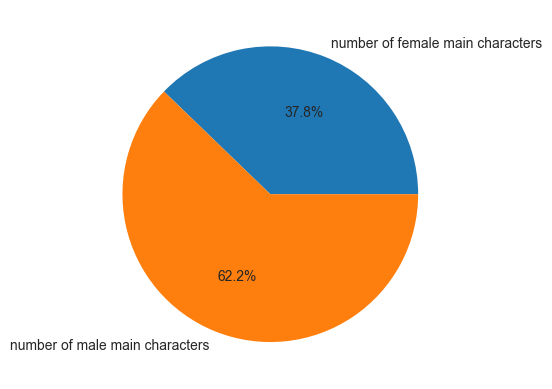

In [ ]:
x=character_occurence[character_occurence['Actor_gender'] == 'F'].count()
print(x)
y=character_occurence[character_occurence['Actor_gender'] == 'M'].count()
#plot x and y in a pie chart
plt.pie([x[0] , y[0]], labels=['number of female main characters', 'number of male main characters'], autopct='%1.1f%%')
plt.show()

## STEP 4 : Discrimination through types of roles attribution and its evolution in time

## Step 4.1: Summaries treatment

In [ ]:
# feminine pronouns occurence in summaries

In [ ]:
def indicator_variable(dic,x,s):
    '''
    Returns indicator variable which equals to 1 if the corresponding headline uses 
    the corresponding type of pronoun and 0 otherwise.
    :param dic: dictionary
    :param x: string
    :param s: string
    :return: indicator variable
    '''
    return int(bool(set(dic[s]) & set(x.lower().split(" "))))

In [ ]:
feature_wordsets = dict([
    # https://en.wikipedia.org/wiki/English_personal_pronouns
    ('fem_pronoun', ['she','her','hers','herself', 
                               "she'll", "she's", 'shes']),
    ('masc_pronoun', ['he','him','his','himself',
                               "he'd", "he's", 'hes'])
])

plot_summaries["fem_pronoun"] = plot_summaries["Plot Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'fem_pronoun'))
plot_summaries["masc_pronoun"] = plot_summaries["Plot Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'masc_pronoun'))


In [ ]:
plot_summaries

,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...",0,0
31186339,The nation of Panem consists of a wealthy Capi...,1,1
20663735,Poovalli Induchoodan is sentenced for six yea...,1,1
2231378,"The Lemon Drop Kid , a New York City swindler,...",1,1
595909,Seventh-day Adventist Church pastor Michael Ch...,1,1
...,...,...,...
34808485,"The story is about Reema , a young Muslim scho...",1,0
1096473,"In 1928 Hollywood, director Leo Andreyev look...",1,1
35102018,American Luthier focuses on Randy Parsons’ tra...,0,1


In [ ]:
length_summaries = len(plot_summaries)

In [ ]:
print('The number of summaries with feminine pronouns occurence:', sum(plot_summaries["fem_pronoun"]))
print('The percentage of summaries with feminine pronouns occurence:', 100*(sum(plot_summaries["fem_pronoun"]))/ length_summaries, "%")

The number of summaries with feminine pronouns occurence: 25181
The percentage of summaries with feminine pronouns occurence: 59.5253291728719 %


In [ ]:
print('The number of summaries with masculine pronouns occurence:', sum(plot_summaries["masc_pronoun"]))
print('The percentage of summaries with masculine pronouns occurence:', 100*(sum(plot_summaries["masc_pronoun"]))/ length_summaries, "%")

The number of summaries with masculine pronouns occurence: 35197
The percentage of summaries with masculine pronouns occurence: 83.2021369642815 %


We observe that there is more than 23% difference between the occurence of feminine and masculine pronouns in the given summaries.

We can check if the pronouns occurence changes through time.

In [ ]:
# add a release date column to the plot_summaries dataset

summaries_with_date = movie_metadata_filt.join(plot_summaries) #there were more summaries than given movies
summaries_with_date = summaries_with_date.dropna()
summaries_with_date["Movie release date"] = pd.to_datetime(summaries_with_date["Movie release date"],errors='coerce')
summaries_with_date = summaries_with_date.sort_values(by="Movie release date")
summaries_with_date 

NameError: name 'movie_metadata_filt' is not defined

In [ ]:
#split dataset into three parts: before 2007, between 2007 and 2016, and after 2016

summaries_before2007 = summaries_with_date[summaries_with_date["Movie release date"] < "2007-01-01"]
summaries_2007 = summaries_with_date[(summaries_with_date["Movie release date"] >= "2007-01-01") & (summaries_with_date["Movie release date"] < "2016-01-01") ]
summaries_2016 = summaries_with_date[summaries_with_date["Movie release date"] >= "2016-01-01"]
summaries_2016

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,,,,,,,,,


In [ ]:
print('The number of summaries before 2007 with feminine pronouns occurence:', sum(summaries_before2007["fem_pronoun"]))
print('The percentage of summaries before 2007 with feminine pronouns occurence:', 100*(sum(summaries_before2007["fem_pronoun"]))/ len(summaries_before2007), "%")

The number of summaries before 2007 with feminine pronouns occurence: 4392.0
The percentage of summaries before 2007 with feminine pronouns occurence: 76.2367644506162 %


In [ ]:
print('The number of summaries before 2007 with masculine pronouns occurence:', sum(summaries_before2007["masc_pronoun"]))
print('The percentage of summaries before 2007 with masculine pronouns occurence:', 100*(sum(summaries_before2007["masc_pronoun"]))/ len(summaries_before2007), "%")

The number of summaries before 2007 with masculine pronouns occurence: 5405.0
The percentage of summaries before 2007 with masculine pronouns occurence: 93.82051727130707 %


In [ ]:
print('The number of summaries after 2007 with feminine pronouns occurence:', sum(summaries_2007["fem_pronoun"]))
print('The percentage of summaries after 2007 with feminine pronouns occurence:', 100*(sum(summaries_2007["fem_pronoun"]))/ len(summaries_2007), "%")

The number of summaries after 2007 with feminine pronouns occurence: 1329.0
The percentage of summaries after 2007 with feminine pronouns occurence: 78.1305114638448 %


In [ ]:
print('The number of summaries after 2007 with masculine pronouns occurence:', sum(summaries_2007["masc_pronoun"]))
print('The percentage of summaries after 2007 with masculine pronouns occurence:', 100*(sum(summaries_2007["masc_pronoun"]))/ len(summaries_2007), "%")

The number of summaries after 2007 with masculine pronouns occurence: 1535.0
The percentage of summaries after 2007 with masculine pronouns occurence: 90.24103468547914 %


the dataset does not contain any row after 2016

On the period before and after 2007, we see a slight increase in feminine pronouns occurence and a slight decrease in masculine pronouns occurences, always with masculine pronouns mainly used in movies summaries. The subgroups tendencies are aligned with the entire group (it is not a Simpson paradox).

These results can not be largely interpreted as the subgroup "before 2007" is fifth times larger than the "after 2007" subgroup. Results can be biased due to the different number of samples.

Find a way to count the number of feminine and masculine pronouns in each summary, compute the mean and the mean difference for both groups. Compare mean number of fem/masc pronouns in function of movies genres. Compare this to length of summary too. (maybe action movies have shorter summaries, and they are also more representative of men population)

The next step would be to correlate the masculine and feminine pronouns occurence with certain genres, and see if it matches certain gender stereotypes.

In [211]:


,Plot_Summary
Wikipedia_movie_ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...
...,...
34808485,"The story is about Reema , a young Muslim scho..."
1096473,"In 1928 Hollywood, director Leo Andreyev look..."
35102018,American Luthier focuses on Randy Parsons’ tra...
